In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms as T
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
# instantiate a ResNet-18 from torchvision
resnet18_instance = models.resnet18()

# print model architecture
print(resnet18_instance)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Load the CIFAR10 dataset

In [16]:
def get_data(batch_size, test_batch_size=256):
  # prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.Resize((227,227)))
  transform.append(T.ToTensor()) # converts numpy to Pytorch tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))  # normalizes the tensors between [-1, 1] 
  transform = T.Compose(transform) # composes the above transformations into one
  # load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

  # create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.8+1)
  validation_samples = num_samples - training_samples
  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

  return train_loader, val_loader, test_loader                                          

Train Resnet18

In [17]:
# define the needed functions to get the loss function
def get_loss_function():
  loss_function = nn.CrossEntropyLoss()
  return loss_function

# optimizer to optimize the weights base on the loss
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

In [18]:
# train the resnet18 instance model
def train(net, data_loader, optimizer, loss_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  with tqdm.tqdm(total=len(data_loader)) as pbar:
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs) # Forward pass
      loss = loss_function(outputs,targets) # Apply the loss
      loss.backward() # Backward pass
      optimizer.step() # Update parameters
      optimizer.zero_grad() # Reset the optimizer
      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()
      pbar.set_postfix_str("training with Current loss: {:.4f}, Accuracy: {:.4f}, at iteration: {:.1f}".format(cumulative_loss/ samples, cumulative_accuracy / samples*100, float(batch_idx)))
      pbar.update()
  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [19]:
#also to test the accuracy of the model we are going to use a test function to test the accuracy over the validation set 
def test(net, data_loader, loss_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  net.eval() # Strictly needed if network contains layers which have different behaviours between train and test
  with tqdm.tqdm(total=len(data_loader)) as pbar:  
    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Load data into GPU
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        loss = loss_function(outputs,targets) 
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        cumulative_accuracy += predicted.eq(targets).sum().item()
        pbar.set_postfix_str("validation with Current loss: {:.4f}, Accuracy: {:.4f}, at iteration: {:.1f}".format(cumulative_loss/ samples, cumulative_accuracy / samples*100, float(batch_idx)))
        pbar.update()
  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [20]:
def trainer(
    # lets define the basic hyperparameters
    batch_size=128,
    learning_rate=0.01,
    weight_decay=0.000001,
    momentum=0.9,
    epochs=10,
    model=None):
  #now we load the data in three splits train, test and validation 
  train_loader, val_loader, test_loader = get_data(batch_size)
  # Moving the resnet to gpu device if it is available
  net = model.to(device)
  # defining the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  # defining the loss function
  loss_function = get_loss_function()
  # finaly training the model 


  # In order to save the accuracy and loss we use a list to save them in each epoch 
  val_loss_list = []
  val_accuracy_list = []
  train_loss_list = []
  train_accuracy_list = []

  for e in range(epochs):
    print('training epoch number {:.2f} of total epochs of {:.2f}'.format(e,epochs))
    train_loss, train_accuracy = train(net, train_loader, optimizer, loss_function)
    val_loss, val_accuracy = test(net, val_loader, loss_function)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)


    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss,
    train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss,
    val_accuracy))
  print('-----------------------------------------------------')
  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, loss_function)
  val_loss, val_accuracy = test(net, val_loader, loss_function)
  test_loss, test_accuracy = test(net, test_loader, loss_function)
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss,
  train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss,
  val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  return val_loss_list, val_accuracy_list, train_loss_list, train_accuracy_list

In [22]:
resnet_val_loss,resnet_val_accuracy, resnet_train_loss,resnet_train_accuracy = trainer(model=resnet18_instance)

Files already downloaded and verified
Files already downloaded and verified
training epoch number 0.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.43it/s, validation with Current loss: 0.0054, Accuracy: 50.7951, at iteration: 39.0]


Epoch: 1
	 Training loss 0.01266, Training accuracy 42.20
	 Validation loss 0.00544, Validation accuracy 50.80
training epoch number 1.00 of total epochs of 10.00


100%|██████████| 40/40 [00:38<00:00,  1.04it/s, validation with Current loss: 0.0044, Accuracy: 61.0661, at iteration: 39.0]


Epoch: 2
	 Training loss 0.00835, Training accuracy 61.43
	 Validation loss 0.00442, Validation accuracy 61.07
training epoch number 2.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.43it/s, validation with Current loss: 0.0044, Accuracy: 61.8062, at iteration: 39.0]


Epoch: 3
	 Training loss 0.00649, Training accuracy 70.24
	 Validation loss 0.00442, Validation accuracy 61.81
training epoch number 3.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.43it/s, validation with Current loss: 0.0037, Accuracy: 69.9470, at iteration: 39.0]


Epoch: 4
	 Training loss 0.00504, Training accuracy 77.21
	 Validation loss 0.00374, Validation accuracy 69.95
training epoch number 4.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.41it/s, validation with Current loss: 0.0032, Accuracy: 74.4074, at iteration: 39.0]


Epoch: 5
	 Training loss 0.00390, Training accuracy 82.45
	 Validation loss 0.00324, Validation accuracy 74.41
training epoch number 5.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.41it/s, validation with Current loss: 0.0040, Accuracy: 69.3069, at iteration: 39.0]


Epoch: 6
	 Training loss 0.00289, Training accuracy 87.12
	 Validation loss 0.00396, Validation accuracy 69.31
training epoch number 6.00 of total epochs of 10.00


100%|██████████| 40/40 [00:29<00:00,  1.34it/s, validation with Current loss: 0.0044, Accuracy: 71.4171, at iteration: 39.0]


Epoch: 7
	 Training loss 0.00191, Training accuracy 91.54
	 Validation loss 0.00443, Validation accuracy 71.42
training epoch number 7.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.41it/s, validation with Current loss: 0.0088, Accuracy: 55.1255, at iteration: 39.0]


Epoch: 8
	 Training loss 0.00126, Training accuracy 94.60
	 Validation loss 0.00884, Validation accuracy 55.13
training epoch number 8.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.39it/s, validation with Current loss: 0.0044, Accuracy: 73.8174, at iteration: 39.0]


Epoch: 9
	 Training loss 0.00077, Training accuracy 96.74
	 Validation loss 0.00440, Validation accuracy 73.82
training epoch number 9.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s, validation with Current loss: 0.0058, Accuracy: 70.9671, at iteration: 39.0]


Epoch: 10
	 Training loss 0.00050, Training accuracy 97.97
	 Validation loss 0.00579, Validation accuracy 70.97
-----------------------------------------------------
After training:


100%|██████████| 79/79 [00:27<00:00,  2.82it/s, validation with Current loss: 0.0112, Accuracy: 71.6100, at iteration: 78.0]

	 Training loss 0.00209, Training accuracy 91.56
	 Validation loss 0.00579, Validation accuracy 70.97
	 Test loss 0.01116, Test accuracy 71.61
-----------------------------------------------------


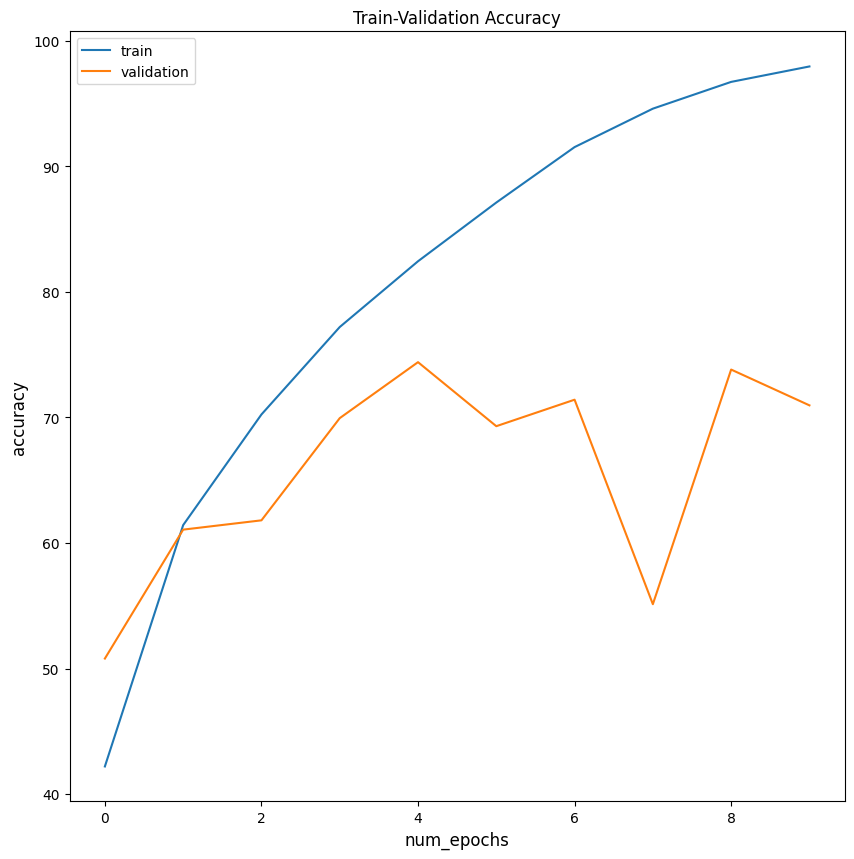

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.title("Train-Validation Accuracy")
plt.plot(resnet_train_accuracy, label='train')
plt.plot(resnet_val_accuracy, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.show()

Try the same with pretrained weights

In [25]:
pretrained_resnet18 = models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.3MB/s]


In [29]:
pre_trained_resnet_val_loss,pre_trained_resnet_val_accuracy, pre_trained_resnet_train_loss,pre_trained_resnet_train_accuracy = trainer(model=pretrained_resnet18)

Files already downloaded and verified
Files already downloaded and verified
training epoch number 0.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.44it/s, validation with Current loss: 0.0012, Accuracy: 90.1990, at iteration: 39.0]


Epoch: 1
	 Training loss 0.00443, Training accuracy 83.16
	 Validation loss 0.00116, Validation accuracy 90.20
training epoch number 1.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.46it/s, validation with Current loss: 0.0010, Accuracy: 92.2692, at iteration: 39.0]


Epoch: 2
	 Training loss 0.00118, Training accuracy 94.86
	 Validation loss 0.00095, Validation accuracy 92.27
training epoch number 2.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.45it/s, validation with Current loss: 0.0009, Accuracy: 93.0093, at iteration: 39.0]


Epoch: 3
	 Training loss 0.00044, Training accuracy 98.12
	 Validation loss 0.00094, Validation accuracy 93.01
training epoch number 3.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.46it/s, validation with Current loss: 0.0008, Accuracy: 93.8894, at iteration: 39.0]


Epoch: 4
	 Training loss 0.00018, Training accuracy 99.31
	 Validation loss 0.00083, Validation accuracy 93.89
training epoch number 4.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.47it/s, validation with Current loss: 0.0008, Accuracy: 94.4094, at iteration: 39.0]


Epoch: 5
	 Training loss 0.00007, Training accuracy 99.81
	 Validation loss 0.00080, Validation accuracy 94.41
training epoch number 5.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.43it/s, validation with Current loss: 0.0008, Accuracy: 94.6995, at iteration: 39.0]


Epoch: 6
	 Training loss 0.00003, Training accuracy 99.95
	 Validation loss 0.00081, Validation accuracy 94.70
training epoch number 6.00 of total epochs of 10.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s, validation with Current loss: 0.0008, Accuracy: 94.9795, at iteration: 39.0]


Epoch: 7
	 Training loss 0.00001, Training accuracy 100.00
	 Validation loss 0.00077, Validation accuracy 94.98
training epoch number 7.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.46it/s, validation with Current loss: 0.0008, Accuracy: 95.0495, at iteration: 39.0]


Epoch: 8
	 Training loss 0.00001, Training accuracy 100.00
	 Validation loss 0.00077, Validation accuracy 95.05
training epoch number 8.00 of total epochs of 10.00


100%|██████████| 40/40 [00:27<00:00,  1.47it/s, validation with Current loss: 0.0008, Accuracy: 95.0795, at iteration: 39.0]


Epoch: 9
	 Training loss 0.00000, Training accuracy 100.00
	 Validation loss 0.00077, Validation accuracy 95.08
training epoch number 9.00 of total epochs of 10.00


100%|██████████| 40/40 [00:26<00:00,  1.49it/s, validation with Current loss: 0.0008, Accuracy: 95.0795, at iteration: 39.0]


Epoch: 10
	 Training loss 0.00000, Training accuracy 100.00
	 Validation loss 0.00078, Validation accuracy 95.08
-----------------------------------------------------
After training:


100%|██████████| 79/79 [00:27<00:00,  2.90it/s, validation with Current loss: 0.0015, Accuracy: 95.1200, at iteration: 78.0]

	 Training loss 0.00000, Training accuracy 100.00
	 Validation loss 0.00078, Validation accuracy 95.08
	 Test loss 0.00155, Test accuracy 95.12
-----------------------------------------------------


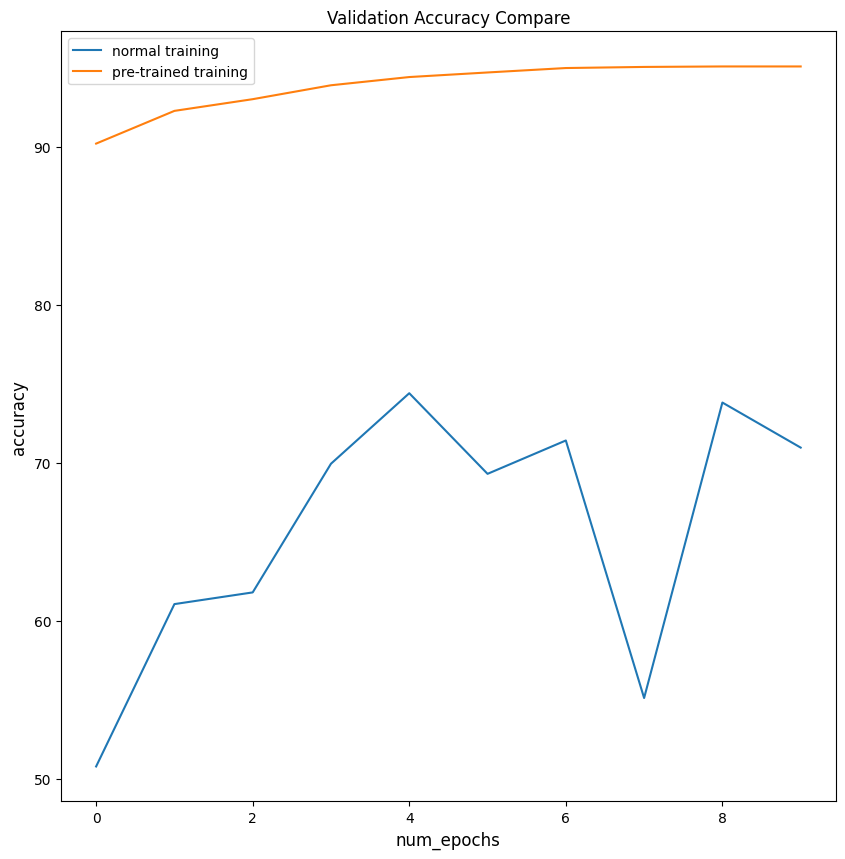

In [30]:
#now we can see the difference between the pre trained model and training from scratch 
fig = plt.figure(figsize=(10,10))
plt.title("Validation Accuracy Compare")
plt.plot(resnet_val_accuracy, label='normal training')
plt.plot(pre_trained_resnet_val_accuracy, label='pre-trained training')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.show()
# As you can see pre trined model started from much better point and achieve better results, as it applies the knowldge learned from imagenet to train
# the new model